In [1]:
%matplotlib widget
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, vmap
from jax.example_libraries import optimizers

# to run this `pip install jax matplotlib jupyter`

# Function to define and evaluate the neural network
#######################################################

def init_network_params(layer_sizes, key):
  keys = jax.random.split(key, len(layer_sizes) - 1)
  params = []
  for key, in_feat, out_feat in zip(keys, layer_sizes[:-1], layer_sizes[1:]):
    r = jnp.sqrt(1./in_feat)
    W = jax.random.uniform(key, (out_feat, in_feat), minval=-r,maxval=r)
    b = jnp.zeros(out_feat)
    params.append((W,b))
  return params

def neural_network(params, X, enforce_bc):
  x,y = X
  for w, b in params[:-1]:
    outputs = jnp.dot(w, X) + b
    X = jax.nn.tanh(outputs)
  final_w, final_b = params[-1]
  output = jnp.dot(final_w,X) + final_b
  if enforce_bc:
    bc_enforcement = x*y*(1-x)*(1-y)
    return jnp.squeeze(output*bc_enforcement)
  return jnp.squeeze(output)

# Training Function
#######################################################

def train(params,loss_fn,num_epochs,X_train,enforce_bc,error_fn=None):
  opt_init, opt_update, get_params = optimizers.adam(1e-3)
  opt_state = opt_init(params) 

  @jax.jit
  def step(opt_state, X):
    params = get_params(opt_state)
    value,grads = jax.value_and_grad(loss_fn)(params, X, enforce_bc)

    error = None
    if error_fn!=None:
      error = error_fn(params,enforce_bc).astype(float)
    return opt_update(0, grads, opt_state),value.astype(float), error

  
  # Training loop
  losses = []
  errors = []
  for epoch in range(num_epochs):
    opt_state,loss,error = step(opt_state, X_train)
    losses.append(loss)
    errors.append(error)
    if epoch % 1000 == 0:
      print(f"Epoch {epoch}, Loss: {loss}, Error: {error}")

  # Get the trained parameters
  return get_params(opt_state), losses, errors

This code trains a PINN to solve
$$
-\nabla^2 u(x,y) = 8 \pi^2 sin(2\pi x) sin(2\pi y)
$$

In [2]:
# for plotting
def plot_2d(trained_params,num_points_plot,enforce_bc,ax):
  points_1d = jnp.linspace(0, 1, num_points_plot)
  X, Y = jnp.meshgrid(points_1d, points_1d)
  flat_points = jnp.stack([X.flatten(),Y.flatten()]).T

  # Evaluate the neural network on the grid
  u_func = vmap(neural_network,in_axes=(None, 0, None))
  Z_flat = u_func(trained_params, flat_points,enforce_bc)
  Z = Z_flat.reshape((num_points_plot, num_points_plot))

  # Plot the surface, and label it
  ax.plot_surface(X, Y, Z, cmap='viridis')
  ax.set_xlabel('X',labelpad=0)
  ax.set_ylabel('Y',labelpad=0)
  ax.set_zlabel('U',labelpad=0)

# Functions to define the PDE and loss function
####################################################

def laplacian(ufunc, X):
  x,y = X
  u = lambda x, y: ufunc(jnp.array([x,y]))
  u_x = grad(u, argnums=0)
  u_y = grad(u, argnums=1)
  u_xx = grad(u_x, argnums=0)
  u_yy = grad(u_y, argnums=1)
  return u_xx(x, y) + u_yy(x, y)

def rhs(X):
  return 8.0*jnp.pi**2 * jnp.sin(2*jnp.pi*X[:,0]) * jnp.sin(2*jnp.pi*X[:,1])

def exact(X):
  return jnp.sin(2*jnp.pi*X[:,0]) * jnp.sin(2*jnp.pi*X[:,1])

def error_fn_expand(params, exact_fn, X, enforce_bc):
  uapprx = vmap(neural_network,in_axes=(None, 0, None))(params, X,enforce_bc)
  uexact = exact_fn(X)
  return jnp.sqrt(jnp.mean((uapprx-uexact) ** 2))

def loss_fn(params, X, enforce_bc):
  ufunc = lambda Xv: neural_network(params,Xv,enforce_bc)
  laplacian_u = vmap(laplacian, in_axes=(None, 0))(ufunc, X)
  rhs_val = rhs(X)
  loss = jnp.mean((-laplacian_u - rhs_val) ** 2)
  return loss

# Build the network and train it
####################################################

# Setup the network
key = jax.random.PRNGKey(3)
layer_sizes = [2, 64, 64, 1]
params = init_network_params(layer_sizes,key)

# Generate training data
num_points = 1000
X_train = jax.random.uniform(key,(num_points,2))

error_fn = lambda params,enforce_bc: error_fn_expand(params,exact,X_train,enforce_bc)
_,losses,errors = train(params,loss_fn,num_epochs=20001,X_train=X_train,
                        enforce_bc=True,error_fn=error_fn)

Epoch 0, Loss: 1573.7503662109375, Error: 0.5023919343948364
Epoch 1000, Loss: 445.88775634765625, Error: 0.2927872836589813
Epoch 2000, Loss: 45.42121887207031, Error: 0.077126644551754
Epoch 3000, Loss: 10.98316764831543, Error: 0.03149210289120674
Epoch 4000, Loss: 3.660318374633789, Error: 0.013877849094569683
Epoch 5000, Loss: 1.5328584909439087, Error: 0.006410281173884869
Epoch 6000, Loss: 0.7538923025131226, Error: 0.0027242223732173443
Epoch 7000, Loss: 0.46806904673576355, Error: 0.0022330277133733034
Epoch 8000, Loss: 0.3113567531108856, Error: 0.002026455709710717
Epoch 9000, Loss: 0.21757929027080536, Error: 0.0012697334168478847
Epoch 10000, Loss: 0.16193078458309174, Error: 0.0008764155209064484
Epoch 11000, Loss: 0.11502621322870255, Error: 0.0006508089136332273
Epoch 12000, Loss: 0.080799400806427, Error: 0.0004685216408688575
Epoch 13000, Loss: 0.060333311557769775, Error: 0.000981332384981215
Epoch 14000, Loss: 0.04350907355546951, Error: 0.00031771851354278624
Epoch

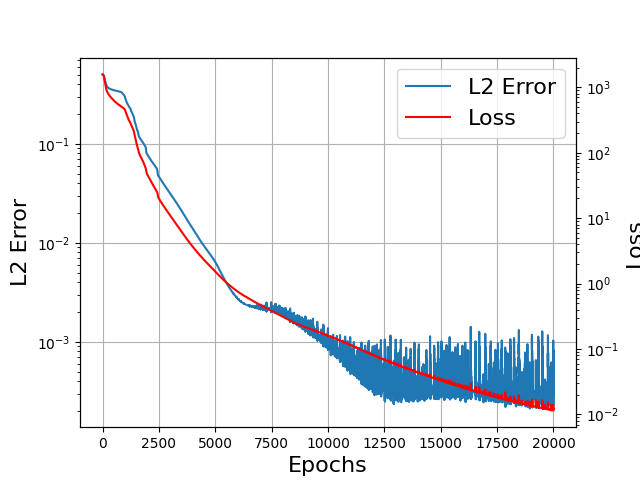

In [3]:
plt.close('all')

losses = [float(l) for l in losses]
errors = [float(e) for e in errors]

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111)
ax_loss = ax.twinx()

lne_err = ax.semilogy(errors,label='L2 Error')
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('L2 Error',fontsize=16)
ax.grid(True)

lne_loss = ax_loss.semilogy(losses,color='red',label='Loss')
ax_loss.set_ylabel('Loss',fontsize=16)

ax.legend([lne_err[0],lne_loss[0]],['L2 Error','Loss'],fontsize=16)

fig.savefig('loss.png',dpi=200,bbox_inches='tight')

plt.show()

In [4]:
def loss_fn_alpha(params, Xfull, enforce_bc,alpha):
  X,Xbc = Xfull
  ufunc = lambda Xv: neural_network(params,Xv,enforce_bc)
  ubc = vmap(neural_network,in_axes=(None, 0, None))(params, Xbc,enforce_bc)
  laplacian_u = vmap(laplacian, in_axes=(None, 0))(ufunc, X)
  rhs_val = rhs(X)
  loss = jnp.mean((-laplacian_u + rhs_val) ** 2) + alpha*jnp.mean((ubc)**2)
  return loss

# Build the network and train it
####################################################

# Setup the network
key = jax.random.PRNGKey(3)

# Generate training data
num_points = 1000
X_train = jax.random.uniform(key,(num_points,2))
bc_points = jnp.linspace(0.0,1,101)
one_points = jnp.ones_like(bc_points)
zero_points = jnp.zeros_like(bc_points)
X_bc = jnp.hstack([jnp.array([bc_points,zero_points]),
                   jnp.array([one_points,bc_points]),
                   jnp.array([bc_points,one_points]),
                   jnp.array([zero_points,bc_points]),
                  ]).T

# train a number of functions
trained_params_list = []
alphas = [None,1.0e-4,1e-2,1e-0,1e+2,1e+4]
for alpha in alphas:
  if alpha==None:
    enforce_bc = True
    alpha = 0.0
  else:
    enforce_bc = False

  local_key = jax.random.PRNGKey(5)
  params = init_network_params(layer_sizes,local_key)

  loss_fn = lambda *p: loss_fn_alpha(*p,alpha)

  trained_params,_,_ = train(params,loss_fn,num_epochs=20001,X_train=(X_train,X_bc),enforce_bc=enforce_bc)
  trained_params_list.append(trained_params)
  print(f'completed alpha = {alpha:.2e}')
  print()

Epoch 0, Loss: 1573.612548828125, Error: None
Epoch 1000, Loss: 285.8049621582031, Error: None
Epoch 2000, Loss: 78.89381408691406, Error: None
Epoch 3000, Loss: 23.761417388916016, Error: None
Epoch 4000, Loss: 9.135756492614746, Error: None
Epoch 5000, Loss: 2.4109363555908203, Error: None
Epoch 6000, Loss: 1.0242211818695068, Error: None
Epoch 7000, Loss: 0.562249481678009, Error: None
Epoch 8000, Loss: 0.3583010733127594, Error: None
Epoch 9000, Loss: 0.24165506660938263, Error: None
Epoch 10000, Loss: 0.17100763320922852, Error: None
Epoch 11000, Loss: 0.11058508604764938, Error: None
Epoch 12000, Loss: 0.07276705652475357, Error: None
Epoch 13000, Loss: 0.04970380291342735, Error: None
Epoch 14000, Loss: 0.0352647602558136, Error: None
Epoch 15000, Loss: 0.026392187923192978, Error: None
Epoch 16000, Loss: 0.020684069022536278, Error: None
Epoch 17000, Loss: 0.017436722293496132, Error: None
Epoch 18000, Loss: 0.01388488244265318, Error: None
Epoch 19000, Loss: 0.0117481313645839

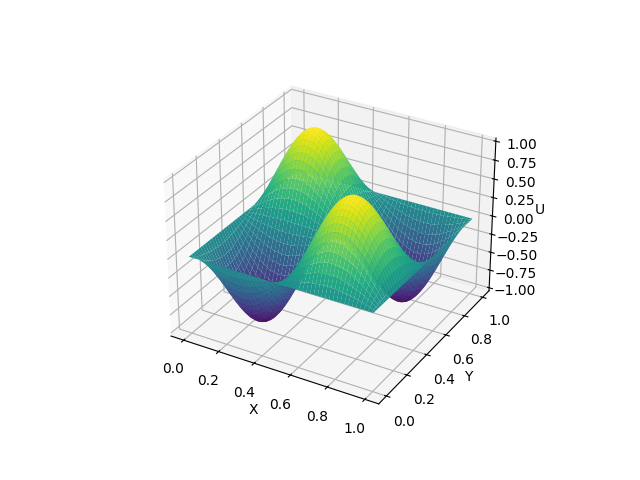

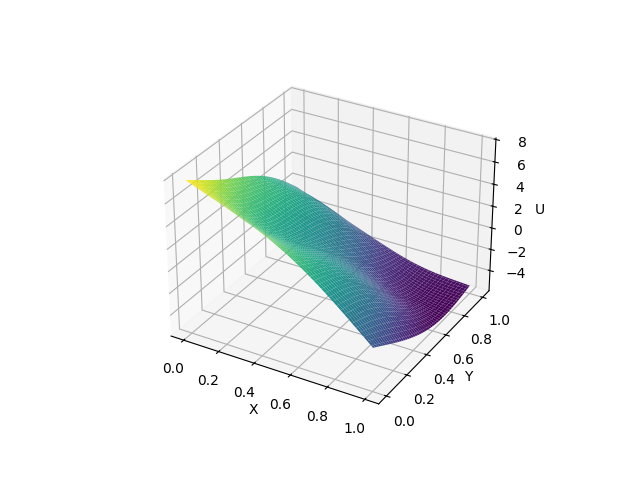

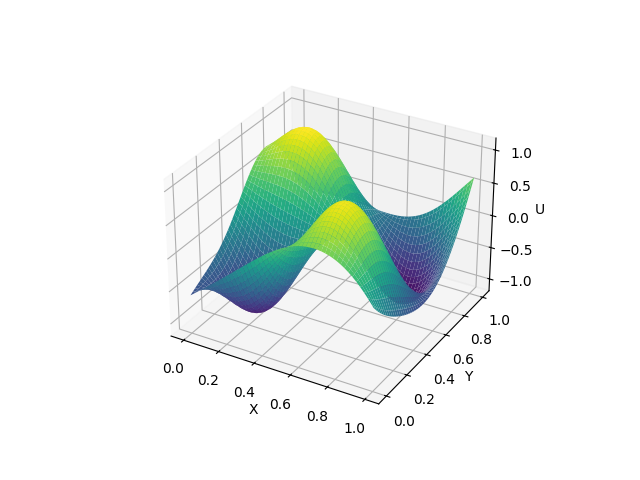

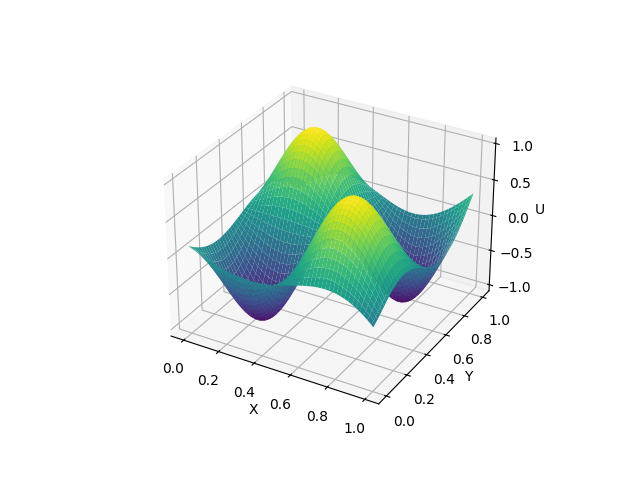

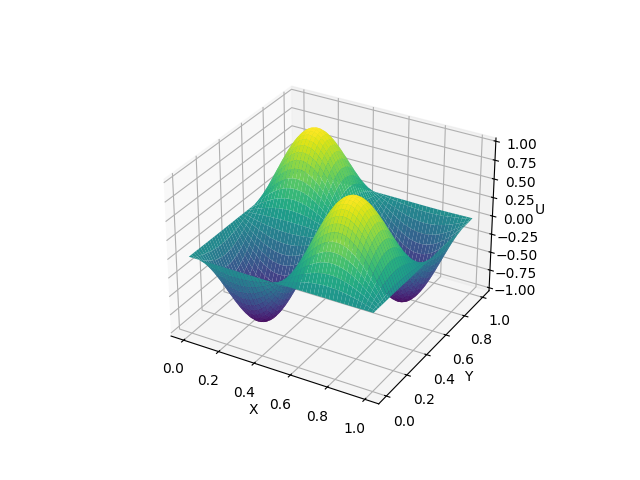

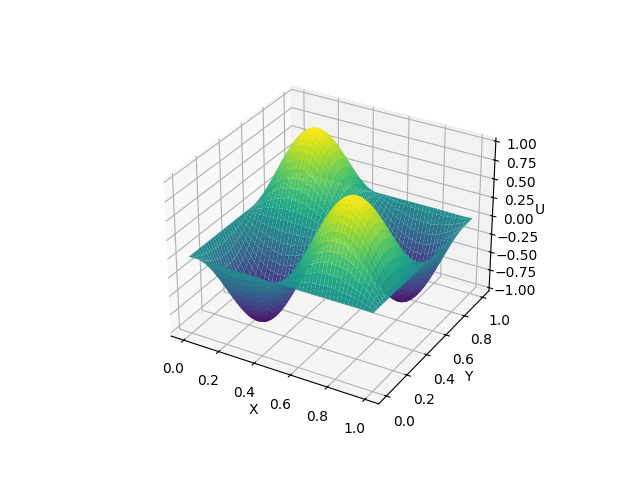

In [5]:
plt.close()

for i,alpha in enumerate(alphas):
  fig = plt.figure()
  fig.tight_layout()
  enforce_bc = False if alpha is not None else True
  ax = fig.add_subplot(1,1,1,projection='3d')
  plot_2d(trained_params_list[i],100,enforce_bc,ax)
  alpha = alpha if alpha is not None else 0.0
  alpha_str = f'alpha:{alpha:.1e}' 
  fig.savefig(f'pinn-{alpha_str}.png',bbox_inches='tight',pad_inches=0.0,dpi=200)